In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import re
import string
import csv
import json
import nltk
import math
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
nltk.download('stopwords')
nltk.download('vader_lexicon')

from collections import Counter, defaultdict

from matplotlib import pyplot as plt
from matplotlib import ticker
import plotly.express as px

# sns.set(style="darkgrid")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# Importing the dataset from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datasetDocument = pd.read_json('/content/drive/My Drive/Colab Notebooks/Proj/Dataset_1/Documents/Documents_Dataset_1.json')
datasetSegmentation = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Proj/Dataset_1/Segmentation/Arms_P1_20_4_6_Prov_Segments.csv')
datasetUserInteractions = pd.read_json('/content/drive/My Drive/Colab Notebooks/Proj/Dataset_1/User Interactions/Arms_P1_InteractionsLogs.json')

In [ ]:
datasetSegmentation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            38 non-null     int64  
 1   start         38 non-null     float64
 2   end           38 non-null     float64
 3   length (sec)  38 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 1.3 KB


In [ ]:
segmentID = datasetSegmentation['ID']
segmentStart = datasetSegmentation['start'] * 10
segmentEnd = datasetSegmentation['end'] * 10
segmentDuration = datasetSegmentation['length (sec)'] * 10

In [ ]:
datasetUserInteractions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   duration         879 non-null    int64 
 1   Text             879 non-null    object
 2   InteractionType  879 non-null    object
 3   ID               879 non-null    object
 4   time             879 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 34.5+ KB


In [ ]:
interactionType = datasetUserInteractions['InteractionType']
interactionText = datasetUserInteractions['Text']
interactionTime = datasetUserInteractions['time']
interactionDuration = datasetUserInteractions['duration']

# Creation of the Dataframe for Interaction Summary

In [ ]:
userSummaryDF = pd.DataFrame(columns=['UserID', 'SegmentID', 'Start', 'End', '# Interactions', '# Documents Opened', 'Opened Documents', 'OpenDuration',
                                      '# Documents Read', 'Read Documents', 'ReadDuration', '# Documents Dragged', 'Dragged Documents', 'DraggingDuration',
                                      'Most Read Document', '# Highlighted', 'Highlighted Words', 'HighlightingDuration', '# Searched', 'Searched Words', 
                                      'SearchDuration'])

totalSegments = len(segmentID)
numOfInteractions = len(interactionTime)
segmentIndex = 0
figureCount = math.ceil(np.sqrt(totalSegments))
uIndex = 0

allSearchedWords = []
allHighlightedWords = []
allReadDocuments = []
allDraggedDocuments = []
allOpenedDocuments = []

while segmentIndex < totalSegments:
  interactionCount = 0
  searchedWords = []
  highlightedWords = []

  draggedDocuments = []
  openedDocuments = []
  readDocuments = []

  openDuration = 0
  readDuration = 0
  draggingDuration = 0
  highlightDuration = 0
  searchDuration = 0

  currTime = int(interactionTime[uIndex])
  end = int(segmentEnd[segmentIndex])

  while currTime <= end:
    if(interactionType[uIndex].lower() == 'search'):
      searchedWords.append(interactionText[uIndex])
      searchDuration += interactionDuration[uIndex]
      interactionCount += 1
    elif(interactionType[uIndex].lower() == 'highlight'):
      highlightedWords.append(interactionText[uIndex])
      highlightDuration += interactionDuration[uIndex]
      interactionCount += 1
    elif(interactionType[uIndex].lower() == 'reading'):
      readDocuments.append(interactionText[uIndex])
      readDuration += interactionDuration[uIndex]
      interactionCount += 1
    elif(interactionType[uIndex].lower() == 'doc_open'):
      openedDocuments.append(interactionText[uIndex])
      openDuration += interactionDuration[uIndex]
      interactionCount += 1
    elif(interactionType[uIndex].lower() == 'draging'):
      draggedDocuments.append(interactionText[uIndex])
      draggingDuration += interactionDuration[uIndex]
      interactionCount += 1
    uIndex += 1

    if(uIndex < numOfInteractions):
      currTime = interactionTime[uIndex]

  swf = dict(Counter(searchedWords))

  searchedWordsFreq = [k for k, v in sorted(swf.items(), key=lambda item: item[1], reverse=True)]

  readDocsFreq = dict(Counter(readDocuments))
  mostReadDocument = str(max(readDocsFreq, key=readDocsFreq.get)) if len(readDocsFreq) != 0 else "NA"

  # All values
  allSearchedWords.extend(searchedWords)
  allHighlightedWords.extend(highlightedWords)
  allReadDocuments.extend(readDocuments)
  allOpenedDocuments.extend(openedDocuments)
  allDraggedDocuments.extend(draggedDocuments)

  startTime = int(segmentStart[segmentIndex])/10
  endTime = int(segmentEnd[segmentIndex])/10

  cntDocumentsOpened = len(openedDocuments)
  uniqueDocumentsOpened = np.unique(openedDocuments)

  cntDocumentsRead = len(readDocuments)
  uniqueDocumentsRead = np.unique(readDocuments)

  cntDocumentsDragged = len(draggedDocuments)
  uniqueDocumentsDragged = np.unique(draggedDocuments)

  cntHighlights = len(highlightedWords)
  cntSearches = len(searchedWords)

  userSummaryDF.loc[len(userSummaryDF.index)] = [1, segmentIndex+1, startTime, endTime, interactionCount, cntDocumentsOpened, 
                                                 uniqueDocumentsOpened, openDuration/10, cntDocumentsRead, uniqueDocumentsRead, readDuration/10, cntDocumentsDragged, 
                                                 uniqueDocumentsDragged, draggingDuration/10, mostReadDocument, cntHighlights, highlightedWords, 
                                                 highlightDuration/10, cntSearches, searchedWordsFreq, searchDuration/10]
  segmentIndex += 1


# Viewing the Dataset

In [ ]:
userSummaryDF

,UserID,SegmentID,Start,End,# Interactions,# Documents Opened,Opened Documents,OpenDuration,# Documents Read,Read Documents,...,# Documents Dragged,Dragged Documents,DraggingDuration,Most Read Document,# Highlighted,Highlighted Words,HighlightingDuration,# Searched,Searched Words,SearchDuration
0,1,1,0.0,112.7,4,0,[],0.0,0,[],...,2,"[Armsdealing 97, Armsdealing 98]",1.9,NA,0,[],0.0,2,"[disease, Nigeria]",2.0
1,1,2,112.7,438.9,26,8,"[Armsdealing 79, Armsdealing 81, Armsdealing 97]",426.0,9,"[Armsdealing 79, Armsdealing 81]",...,7,"[Armsdealing 79, Armsdealing 81, Armsdealing 97]",5.5,Armsdealing 81,1,[FUNSHO KAPOLALUM],1.0,1,[gun],1.0
2,1,3,438.9,586.1,18,1,[Armsdealing 98],42.6,8,"[Armsdealing 97, Armsdealing 98]",...,4,"[Armsdealing 79, Armsdealing 81, Armsdealing 9...",2.8,Armsdealing 97,2,"[Kenya, Also recovered were 150 guns]",2.0,3,"[nigeria, gun]",3.0
3,1,4,586.1,590.8,1,0,[],0.0,0,[],...,0,[],0.0,NA,0,[],0.0,1,[kenya],1.0
4,1,5,590.8,636.6,6,1,[Armsdealing 100],35.7,1,[Armsdealing 100],...,1,[Armsdealing 98],1.0,Armsdealing 100,0,[],0.0,3,"[gun, nigeria, nigeria gun]",3.0
5,1,6,636.6,655.5,6,1,[Armsdealing 84],23.3,1,[Armsdealing 100],...,2,"[Armsdealing 100, Armsdealing 84]",1.5,Armsdealing 100,0,[],0.0,2,"[nigeria + gun, nigeria]",2.0
6,1,7,655.5,663.7,3,0,[],0.0,1,[Armsdealing 84],...,0,[],0.0,Armsdealing 84,0,[],0.0,2,"[gun, nigeria]",2.0
7,1,8,663.7,673.4,1,0,[],0.0,0,[],...,0,[],0.0,NA,0,[],0.0,1,[gun],1.0
8,1,9,673.4,680.7,3,1,[Armsdealing 65],240.3,0,[],...,2,[Armsdealing 65],1.8,NA,0,[],0.0,0,[],0.0
9,1,10,680.7,851.6,11,1,[Armsdealing 97],5.3,6,[Armsdealing 65],...,0,[],0.0,Armsdealing 65,1,"[February 1, 2009]",1.0,3,"[nigeria, gun]",3.0


# Exporting the Dataset

In [ ]:
userSummaryDF.to_csv(r'/content/drive/My Drive/Colab Notebooks/Proj/Dataset_3/Summaries/Dataset3_4.csv')

# Dividing the dataset into multiple Segments & average value calculation for each interaction

In [ ]:
userSummaryDF.head()

,SegmentRangeID,SegmentID,Start,End,# Interactions,# Documents Opened,Opened Documents,OpenDuration,# Documents Read,Read Documents,...,# Documents Dragged,Dragged Documents,DraggingDuration,Most Read Document,# Highlighted,Highlighted Words,HighlightingDuration,# Searched,Searched Words,SearchDuration
0,1,1,0.0,326.9,19,2,"[Armsdealing 68, Armsdealing 72]",394.2,2,[Armsdealing 68],...,12,"[Armsdealing 101, Armsdealing 102, Armsdealing...",33.3,Armsdealing 68,1,[Nigeria in February of 2009],1.0,2,"{'arms': 1, 'Nigeria': 1}",2.0
1,1,2,326.9,467.1,43,2,"[Armsdealing 65, Armsdealing 69]",1459.5,35,"[Armsdealing 65, Armsdealing 72]",...,5,"[Armsdealing 65, Armsdealing 69, Armsdealing 72]",4.7,Armsdealing 72,0,[],0.0,1,{'Minsky': 1},1.0
2,1,3,467.1,717.2,43,3,"[Armsdealing 4, Armsdealing 6, Armsdealing 79]",16.6,34,"[Armsdealing 65, Armsdealing 69, Armsdealing 72]",...,2,"[Armsdealing 69, Armsdealing 72]",2.7,Armsdealing 69,3,"[ Leonid Minsky, gun shipments to Yemen, Nigeria]",3.0,1,{'Nigeria': 1},1.0
3,1,4,717.2,734.4,1,1,[Armsdealing 84],114.2,0,[],...,0,[],0.0,NA,0,[],0.0,0,{},0.0
4,1,5,734.4,1542.5,59,4,"[Armsdealing 81, Armsdealing 85]",480.9,37,"[Armsdealing 69, Armsdealing 81, Armsdealing 8...",...,16,"[Armsdealing 72, Armsdealing 81, Armsdealing 85]",35.0,Armsdealing 81,2,[ THE ENTIRE FUNDS TRANSFER WOULD STILL BE IN ...,2.0,0,{},0.0


In [ ]:
df_RangeAverage = pd.DataFrame(columns=['SegmentRangeID', 'SegmentSize', 'Open_Count', 'AverageOpens', 'ReadDocument_Count', 'AverageReads', 
                                        'DraggedDocument_Count', 'AverageDrags', 'HighlightCount', 'AverageHighlights', 'SearchCount', 'AverageSearches'])

figureCount = math.ceil(np.sqrt(totalSegments))
segmentRangeID = 0
count = 0

while(count < totalSegments):
  currFigureCount = 0

  openCount = 0
  readCount = 0
  dragCount = 0
  highlightCount = 0
  searchCount = 0

  while(count < totalSegments and currFigureCount < figureCount):
    openCount += userSummaryDF.iloc[count]["# Documents Opened"]
    readCount += userSummaryDF.iloc[count]["# Documents Read"]
    dragCount += userSummaryDF.iloc[count]["# Documents Dragged"]
    highlightCount += userSummaryDF.iloc[count]["# Highlighted"]
    searchCount += userSummaryDF.iloc[count]["# Searched"]

    currFigureCount += 1
    count += 1
  segmentRangeID += 1
  df_RangeAverage.loc[len(df_RangeAverage.index)] = [segmentRangeID, currFigureCount, openCount, str(round(openCount/currFigureCount, 1)), readCount, str(round(readCount/currFigureCount, 2)), 
                                                     dragCount, str(round(dragCount/currFigureCount, 2)), highlightCount, str(round(highlightCount/currFigureCount, 2)), 
                                                     searchCount, str(round(searchCount/currFigureCount, 2))]

df_RangeAverage

,SegmentRangeID,SegmentSize,Open_Count,AverageOpens,ReadDocument_Count,AverageReads,DraggedDocument_Count,AverageDrags,HighlightCount,AverageHighlights,SearchCount,AverageSearches
0,1,5,12,2.4,108,21.6,35,7.0,6,1.2,4,0.8
1,2,5,18,3.6,58,11.6,61,12.2,0,0.0,6,1.2
2,3,5,12,2.4,20,4.0,3,0.6,0,0.0,5,1.0
3,4,5,44,8.8,46,9.2,33,6.6,2,0.4,12,2.4
4,5,3,5,1.7,0,0.0,0,0.0,0,0.0,0,0.0


# Exporting Segment Range

In [ ]:
df_RangeAverage.to_csv(r'/content/drive/My Drive/Colab Notebooks/Proj/segmentRangeDataset.csv')

In [ ]:
# Cleaning the dataset
def createWordCloud(cList, title, isDoc = False):
  temp = []
  for word in cList:
    words = word.strip().strip("\\").split(" ") if not isDoc else word.replace(" ", "")
    if not isDoc:
      for item in words:
        if item.isalnum():
          temp.append(item.lower())
    else:
      temp.append(words.lower())


  # Making a word cloud for 20 words
  wCloud = " ".join(sorted(Counter(temp)))
  wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  min_font_size = 10, include_numbers=True).generate(wCloud)
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.title(title)
  plt.show()

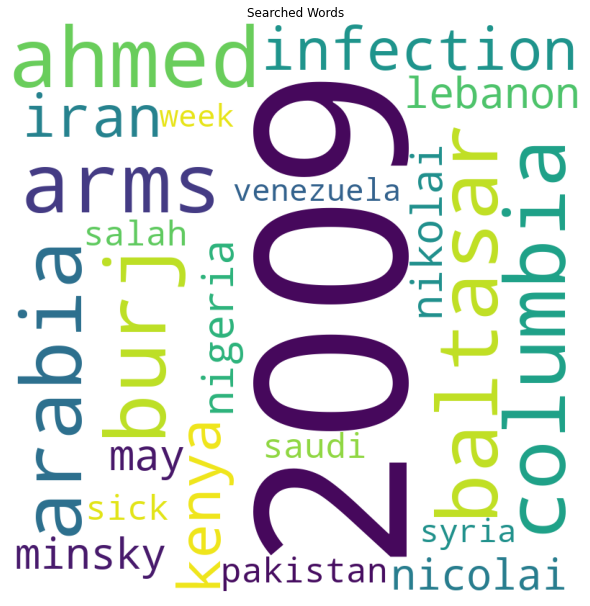

In [ ]:
createWordCloud(allSearchedWords, "Searched Words")

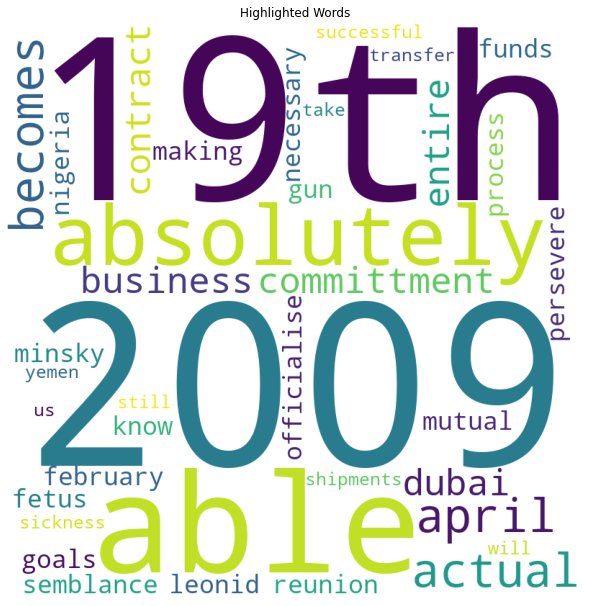

In [ ]:
createWordCloud(allHighlightedWords, "Highlighted Words")

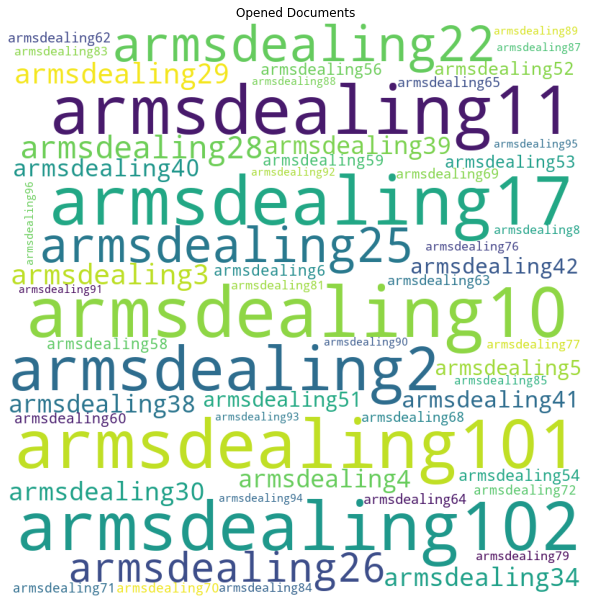

In [ ]:
createWordCloud(allOpenedDocuments, "Opened Documents", True)

# Creation of User Interaction Summary Dataset

In [ ]:
datasetDocument = pd.read_json('/content/drive/My Drive/Colab Notebooks/Proj/Dataset_3/Document/Documents_Dataset_3.json')
datasetSegmentation = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Proj/Dataset_3/Segmentation/Disappearance_P8_20_3_6_Prov_Segments.csv')
datasetUserInteractions = pd.read_json('/content/drive/My Drive/Colab Notebooks/Proj/Dataset_3/User Interactions/Disappearance_P8_InteractionsLogs.json')
userID = 8

segmentID = datasetSegmentation['ID']
segmentStart = datasetSegmentation['start'] * 10
segmentEnd = datasetSegmentation['end'] * 10
segmentDuration = datasetSegmentation['length (sec)'] * 10

interactionType = datasetUserInteractions['InteractionType']
interactionText = datasetUserInteractions['Text']
interactionTime = datasetUserInteractions['time']
interactionDuration = datasetUserInteractions['duration']

userInteractionSummaryDF = pd.DataFrame(columns=['UserID', 'InteractionType', 'Interaction Count', 'Interaction Duration'])

totalSegments = len(segmentID)
numOfInteractions = len(interactionTime)
segmentIndex = 0
uIndex = 0
l = []

openDuration, cntDocumentsOpened = 0, 0
readDuration, cntDocumentsRead = 0, 0
draggingDuration, cntDocumentsDragged = 0, 0
highlightDuration, cntHighlights = 0, 0
searchDuration, cntSearches = 0, 0

while segmentIndex < totalSegments:

  currTime = int(interactionTime[uIndex])
  end = int(segmentEnd[segmentIndex])

  while currTime <= end:
    if(uIndex == len(interactionType)):
      break
    if(interactionType[uIndex].lower() == 'search'):
      searchDuration += interactionDuration[uIndex]
      cntSearches += 1
    elif(interactionType[uIndex].lower() == 'highlight'):
      highlightDuration += interactionDuration[uIndex]
      cntHighlights += 1
    elif(interactionType[uIndex].lower() == 'reading'):
      readDuration += interactionDuration[uIndex]
      cntDocumentsRead += 1
    elif(interactionType[uIndex].lower() == 'doc_open'):
      openDuration += interactionDuration[uIndex]
      cntDocumentsOpened += 1
    elif(interactionType[uIndex].lower() == 'draging'):
      draggingDuration += interactionDuration[uIndex]
      cntDocumentsDragged += 1
    uIndex += 1

    if(uIndex < numOfInteractions):
      currTime = interactionTime[uIndex]
  l.append(cntDocumentsOpened)
  segmentIndex += 1
userInteractionSummaryDF.loc[len(userInteractionSummaryDF.index)] = [userID, 'Searches Performed', cntSearches, searchDuration//10]
userInteractionSummaryDF.loc[len(userInteractionSummaryDF.index)] = [userID, 'Highlights', cntHighlights, highlightDuration//10]
userInteractionSummaryDF.loc[len(userInteractionSummaryDF.index)] = [userID, 'Documents Opened', cntDocumentsOpened, readDuration//10]
userInteractionSummaryDF.loc[len(userInteractionSummaryDF.index)] = [userID, 'Documents Dragged', cntDocumentsDragged, draggingDuration//10]
userInteractionSummaryDF

userInteractionSummaryDF.to_excel(r'/content/drive/My Drive/Colab Notebooks/Proj/d3u8ILogSummary.xlsx')